In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt
import pandas as pd
from cloudy_fit_lib import *
from scipy.interpolate import RegularGridInterpolator
import pickle
import emcee
import corner

In [2]:
plt.style.use('/Users/thepoetoftwilight/Documents/CUBS/Code/science.mplstyle')

In [3]:
rootdir = '/Users/thepoetoftwilight/Documents/CUBS/Data/PG1522+101/cloudy_grids/hm12_vs_hm05/z=0.5/'

Obtain the UVB grid from FG20

In [4]:
fg20_z_grid, fg20_wav_grid, fg20_J_nu_grid = read_uvb('', 'hm05_galaxy.ascii')#'fg20_galaxy.ascii')

Fetch the SED at $z=0.5$

In [5]:
z_test = 0.5

In [6]:
fg20_J_nu_test = fetch_sed(z_test, fg20_z_grid, fg20_J_nu_grid)

Specify grid points

In [7]:
log_hdens_min = -3
log_hdens_max = -1.5
log_hdens_step = 0.25

log_hdens_arr = np.arange(log_hdens_min, log_hdens_max+log_hdens_step, log_hdens_step)

In [8]:
log_metals_min = -1.5
log_metals_max = 0.5
log_metals_step = 0.25

log_metals_arr = np.arange(log_metals_min, log_metals_max+log_metals_step, log_metals_step)

Load column densities

In [9]:
species_logN_samples = {}

In [10]:
#for i in range(len(logN_HI_arr)):

#    logN_HI = logN_HI_arr[i]

# The filename corresponding to the current stopping HI column density
#filename = file_list[i]
    
# Get list of densities and metallicities for this stopping HI column density 
log_hdens_grid, log_metals_grid = read_grd_file(rootdir, 'igm_lalpha_hm12_grid_1750')

# Get average (log) HI temperatures for all grid points
#log_temps_grid = read_avr_file(rootdir, 'igm_lalpha_hm12_grid_1750')

# Get column densities for all species
species_names, log_col_dens_grid = read_col_file(rootdir, 'igm_lalpha_hm12_grid_1750')

for j in range(len(log_hdens_arr)):

    log_hdens = log_hdens_arr[j]

    for k in range(len(log_metals_arr)):

        log_metals = log_metals_arr[k]

        # Get grid index number for the current n_H and metallicity
        idx = np.intersect1d(np.where(log_hdens_grid==log_hdens)[0], np.where(log_metals_grid==log_metals)[0])[0]

        # Isolate the average temperature and column density for all species
        #log_temp = log_temps_grid[idx]
        log_col_dens = log_col_dens_grid[idx]

        # For each species
        for l in range(len(species_names)):

            s = species_names[l]

            if s not in species_logN_samples.keys():

                species_logN_samples[s] = -99.*np.ones((len(log_hdens_arr),
                                                        len(log_metals_arr)))

            # Check for photoionized gas and converged logN(HI)
            #if log_temp>log_T_pie_thresh and np.round(log_col_dens[0],2) == logN_HI:
            species_logN_samples[s][j,k] = log_col_dens[l]

/Users/thepoetoftwilight/Documents/CUBS/Code/cloudy_fit/cloudy_fit_lib.py:434: RuntimeWarning: divide by zero encountered in log10
  log_col_dens = np.log10(np.array(col_lines_split[1::2], dtype=float))


Interpolate

In [11]:
species_logN_interp = {}

for s in list(species_logN_samples.keys()):
    
    species_logN_samples[s][species_logN_samples[s]==-np.inf] = -99
    
    species_logN_interp[s] = RegularGridInterpolator((log_hdens_arr, log_metals_arr), 
                                                     species_logN_samples[s])

Measured column densities

In [12]:
logN_dict = {'HI':'17.46, -0.02, +0.02',
        'CII':'>15.5',
        'CIII':'>13.5',
        'NII':'>14.1',
        'NIII':'<13.2',
        'OII':'>14.8',
        'MgI': '11.42, -0.04, +0.04',
        'MgII': '13.46, -0.05, +0.05',
        'SII': '13.8, -0.3, +0.3',
        'SIII': '14.2, -0.1, +0.1',
        'FeII': '13.91, -0.05, +0.05'}

Constrain ionization parameter

In [13]:
gen_logN_ratio_str(logN_dict['SII'], logN_dict['SIII'])

'-0.40, -0.32, 0.32'

In [14]:
gen_logN_ratio_str(logN_dict['MgII'], logN_dict['SIII'])

'-0.74, -0.11, 0.11'

In [15]:
gen_logN_ratio_str(logN_dict['MgI'], logN_dict['MgII'])

'-2.04, -0.06, 0.06'

In [16]:
log_hdens_plot = np.arange(-3.0, -1.5, 0.01)
logN_SII = np.array([species_logN_interp['S+']([d, -1.0]) for d in log_hdens_plot])
logN_SIII = np.array([species_logN_interp['S+2']([d, -1.0]) for d in log_hdens_plot])
logN_MgII = np.array([species_logN_interp['Mg+']([d, -1.0]) for d in log_hdens_plot])
logN_MgI = np.array([species_logN_interp['Mg']([d, -1.0]) for d in log_hdens_plot])


logN_SII_SIII = (logN_SII-logN_SIII).flatten()
logN_MgII_SIII = (logN_MgII-logN_SIII).flatten()
logN_MgI_MgII = (logN_MgI-logN_MgII).flatten()

In [31]:
idx1 = (logN_SII_SIII>-0.40-0.32)&(logN_SII_SIII<-0.40+0.32)
idx2 = (logN_MgII_SIII>-0.74-0.11)&(logN_MgII_SIII<-0.74+0.11)
idx3 = (logN_MgI_MgII>-2.04-0.06)&(logN_MgI_MgII<-2.04+0.06)

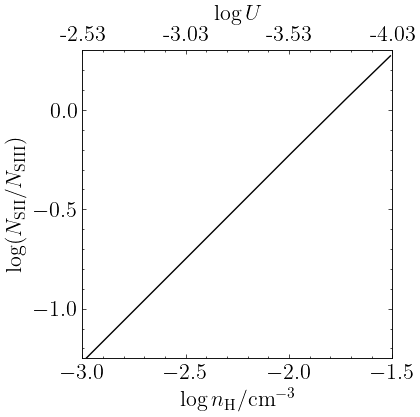

In [32]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.plot(log_hdens_plot,logN_SII_SIII, color='black')
#ax.plot(log_hdens_plot[idx1], logN_SII_SIII[idx1], color='black', lw=4)

#ax.plot(log_hdens_plot,logN_MgII_SIII, color='black')
#ax.plot(log_hdens_plot[idx2], logN_MgII_SIII[idx2], color='black', lw=4)

ax_copy = ax.twiny()
ax_copy.set_xticks([-3, -2.5, -2, -1.5],[-2.53,-3.03,-3.53,-4.03])

#ax.axhspan(0.1, 0.7, color='yellow', alpha=.1)

ax.set_xlim(-3., -1.5)
ax_copy.set_xlim(-3., -1.5)

ax.set_ylim(-1.25,0.3)

ax_copy.set_xlabel(r'$\log U$')
ax.set_xlabel(r'$\log n_\mathrm{H}/\mathrm{cm}^{-3}$')
ax.set_ylabel(r'$\log(N_\mathrm{SII}/N_\mathrm{SIII})$')

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/SII_SIII_model.png', dpi=300)

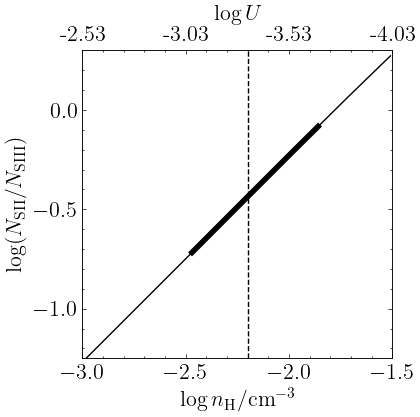

In [33]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.plot(log_hdens_plot,logN_SII_SIII, color='black')
ax.plot(log_hdens_plot[idx1], logN_SII_SIII[idx1], color='black', lw=4)

ax.axvline(-2.2, linestyle='--')
#ax.plot(log_hdens_plot,logN_MgII_SIII, color='black')
#ax.plot(log_hdens_plot[idx2], logN_MgII_SIII[idx2], color='black', lw=4)

ax_copy = ax.twiny()
ax_copy.set_xticks([-3, -2.5, -2, -1.5],[-2.53,-3.03,-3.53,-4.03])

#ax.axhspan(0.1, 0.7, color='yellow', alpha=.1)

ax.set_xlim(-3., -1.5)
ax_copy.set_xlim(-3., -1.5)

ax.set_ylim(-1.25,0.3)

ax_copy.set_xlabel(r'$\log U$')
ax.set_xlabel(r'$\log n_\mathrm{H}/\mathrm{cm}^{-3}$')
ax.set_ylabel(r'$\log(N_\mathrm{SII}/N_\mathrm{SIII})$')

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/SII_SIII_obs.png', dpi=300)

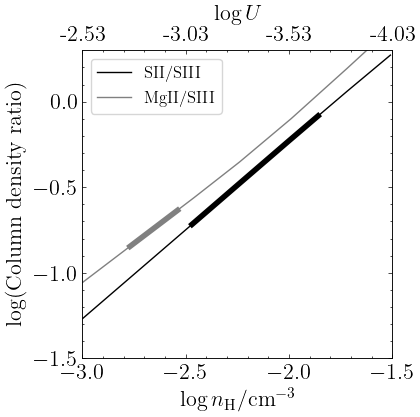

In [39]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.plot(log_hdens_plot,logN_SII_SIII, color='black', label='SII/SIII')
ax.plot(log_hdens_plot[idx1], logN_SII_SIII[idx1], color='black', lw=4)

ax.plot(log_hdens_plot,logN_MgII_SIII, color='gray', label='MgII/SIII')
ax.plot(log_hdens_plot[idx2], logN_MgII_SIII[idx2], color='gray', lw=4)

#ax.plot(log_hdens_plot,logN_MgI_MgII, color='firebrick', label='MgI/MgII')
#ax.plot(log_hdens_plot[idx3], logN_MgI_MgII[idx3], color='firebrick', lw=4)

ax_copy = ax.twiny()
ax_copy.set_xticks([-3, -2.5, -2, -1.5],[-2.53,-3.03,-3.53,-4.03])

#ax.axhline(-0.6)
ax.axhspan(-2.04-0.06, -2.04+0.06, color='firebrick', alpha=.1)

ax.set_xlim(-3., -1.5)
ax_copy.set_xlim(-3., -1.5)

ax.set_ylim(-1.5,0.3)

ax.legend()

ax_copy.set_xlabel(r'$\log U$')
ax.set_xlabel(r'$\log n_\mathrm{H}/\mathrm{cm}^{-3}$')

ax.set_ylabel(r'log(Column density ratio)')

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Mg_depl.png', dpi=300)

In [23]:
logN_SII = np.array([species_logN_interp['S+']([d, -1.]) for d in log_hdens_plot])
logN_CII = np.array([species_logN_interp['C+']([d, -1.]) for d in log_hdens_plot])

logN_CII_SII = (logN_CII-logN_SII).flatten()

In [24]:
gen_logN_ratio_str(logN_dict['CIII'], logN_dict['SIII'])

'>-0.70, 0.35'

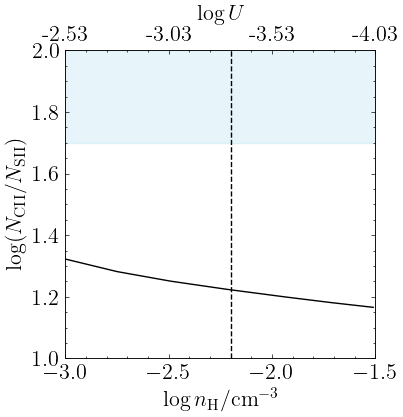

In [49]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.plot(log_hdens_plot,logN_CII_SII, color='black')

ax.axhspan(1.7, 2.0, color='skyblue', alpha=.2)
#ax.axhline(-0.29, color='black', linestyle='--')

#ax.axvspan(-0.29-0.11, -0.29+0.11, color='skyblue', alpha=.2)
ax.axvline(-2.2, color='black', linestyle='--')

ax_copy = ax.twiny()
ax_copy.set_xticks([-3, -2.5, -2, -1.5],[-2.53,-3.03,-3.53,-4.03])

#ax.axhspan(0.1, 0.7, color='yellow', alpha=.1)

ax.set_xlim(-3., -1.5)
ax_copy.set_xlim(-3., -1.5)

ax.set_ylim(1.,2.0)

ax_copy.set_xlabel(r'$\log U$')
ax.set_xlabel(r'$\log n_\mathrm{H}/\mathrm{cm}^{-3}$')

ax.set_ylabel(r'$\log(N_\mathrm{CII}/N_\mathrm{SII})$')

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/C_S.png', dpi=300)

In [42]:
logN_FeII = np.array([species_logN_interp['Fe+']([d, -1.]) for d in log_hdens_plot])
logN_SII = np.array([species_logN_interp['S+']([d, -1.]) for d in log_hdens_plot])

logN_FeII_SII_1 = (logN_FeII-logN_SII).flatten()

logN_FeII = np.array([species_logN_interp['Fe+']([d, -.5]) for d in log_hdens_plot])
logN_SII = np.array([species_logN_interp['S+']([d, -.5]) for d in log_hdens_plot])

logN_FeII_SII_2 = (logN_FeII-logN_SII).flatten()

In [43]:
gen_logN_ratio_str(logN_dict['FeII'], logN_dict['SII'])

'0.11, -0.30, 0.30'

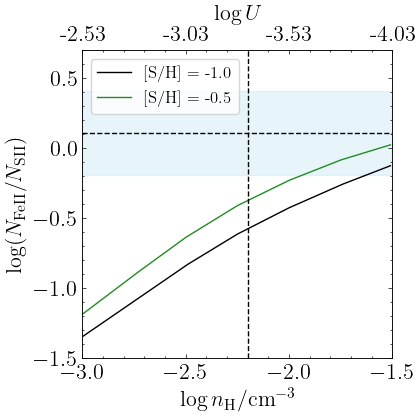

In [50]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.plot(log_hdens_plot,logN_FeII_SII_1, color='black', label=r'[S/H] = -1.0')
ax.plot(log_hdens_plot,logN_FeII_SII_2, color='forestgreen', label=r'[S/H] = -0.5')

ax.axhspan(1.7, 2.0, color='skyblue', alpha=.2)
ax.axhline(0.11, color='black', linestyle='--')

ax.axhspan(0.11-0.30, 0.11+0.30, color='skyblue', alpha=.2)
#ax.axvspan(-0.29-0.11, -0.29+0.11, color='skyblue', alpha=.2)
ax.axvline(-2.2, color='black', linestyle='--')

ax_copy = ax.twiny()
ax_copy.set_xticks([-3, -2.5, -2, -1.5],[-2.53,-3.03,-3.53,-4.03])

#ax.axhspan(0.1, 0.7, color='yellow', alpha=.1)

ax.set_xlim(-3., -1.5)
ax_copy.set_xlim(-3., -1.5)

ax.set_ylim(-1.5,0.7)

ax_copy.set_xlabel(r'$\log U$')
ax.set_ylabel(r'$\log(N_\mathrm{FeII}/N_\mathrm{SII})$')
ax.set_xlabel(r'$\log n_\mathrm{H}/\mathrm{cm}^{-3}$')

ax.legend()

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/Fe_S.png', dpi=300)

In [27]:
log_metals_plot = np.arange(-1.0, 0.5, .01)
logN_SII = np.array([species_logN_interp['S+']([-2.25, m]) for m in log_metals_plot]).flatten()
idx1 = (logN_SII>13.76-0.31)&(logN_SII<13.76+0.31)&(log_metals_plot<0.2)

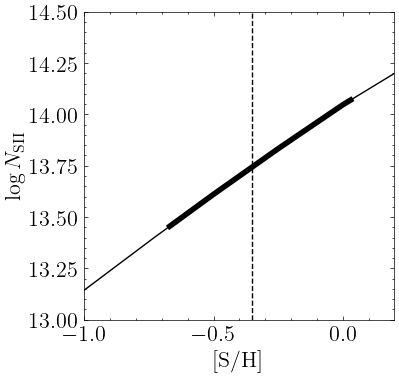

In [28]:
fig, ax = plt.subplots(1, figsize=(4,4))

ax.plot(log_metals_plot,logN_SII, color='black')
ax.plot(log_metals_plot[idx1],logN_SII[idx1], color='black', lw=4)

#ax.axhspan(13.7-0.27, 13.7+0.31, color='skyblue', alpha=.2)
#ax.axhline(13.76, linestyle='--')
ax.axvline(-0.35, linestyle='--')

#ax.axhspan(13.76-0.27, 13.76+0.31, color='skyblue', alpha=.2)

ax.set_xlim(-1.0, 0.2)
ax.set_ylim(13.0, 14.5)

ax.set_xlabel(r'$\mathrm{[S/H]}$')
ax.set_ylabel(r'$\log N_\mathrm{SII}$')

plt.savefig('/Users/thepoetoftwilight/Documents/CUBS/S_H.png', dpi=300)

Fit ions

In [23]:
logN_HI_test = 17.46

In [24]:
def log_prior(params):
    

    # Grid parameters being varied
    log_hdens, log_metals = params
    
    # If the sampled density is within the CLOUDY limits
    # Avoid edges?
    if log_hdens_min<log_hdens<log_hdens_max and log_metals_min<log_metals<log_metals_max:
        return 0.
    else:
        return -np.inf

In [25]:
def log_likelihood(params, logN_dict, species_logN_interp):

    '''
    Likelihood function for comparing CLOUDY predicted column densities to the observed values from VP fit.
    If only some of the parameters need to be fit, the log_likelihood function can be overridden with a lambda function
    which calls this likelihood function with only some parameters being varied.

    params: parameters needed to generate CLOUDY predicted column densities
    logN_dict: dictionary of measured column densities from VP fit
    species_logN_interp: interpolated CLOUDY grid
    '''
    
    # Grid parameters being varied
    log_hdens, log_metals = params

    # Likelihood function
    ll = 0
    
    ions = list(logN_dict.keys())
    
    # Ignore first entry since it's HI
    for i in range(len(ions)):
        
        # This is from VP fit
        ion = ions[i]
        logN_str = logN_dict[ion]
        
        # This is from CLOUDY
        s = ion_species_dict[ion]
        
        # Get interpolated column density from CLOUDY grid
        y_bar = species_logN_interp[s]([log_hdens, log_metals])[0]

        # Based on detection or non-detection, compute the likelihood term
        
        # Detection
        if logN_str[0] != '<' and logN_str[0] != '>':
            
            logN_arr = np.array(logN_str.split(','), dtype=float)
            
            # Observed column density
            y = logN_arr[0]

            # Use max of lower and upper error for defining Gaussian distribution of column density
            sig_y = max(-logN_arr[1], logN_arr[2])

            # Gaussian likelihood
            ll += -.5*(y-y_bar)**2/sig_y**2

        # Upper limit
        elif logN_str[0] == '<':
            
            logN_arr = np.array(logN_str[1:].split(','), dtype=float)

            # Isolate the lower limit and sigma
            y = logN_arr[0]
            sig_y = 0.22

            y_range_min = -10 # Should extend to infinity, ideally
            y_range_step = 0.05

            y_range = np.arange(y_range_min, y+y_range_step, y_range_step)

            # CDF, marginalize over reported values
            ll += np.log(integrate.simpson(x=y_range, y=np.exp(-.5*(y_range-y_bar)**2/sig_y**2)))
            
        # Lower limit
        # NOTE: not implemented yet
        elif logN_str[0] == '>':

            logN_arr = np.array(logN_str[1:].split(','), dtype=float)

            # Isolate the lower limit and sigma
            y = logN_arr[0]
            sig_y = 0.22

            y_range_max = 21.5 # Should extend to infinity, ideally
            y_range_step = 0.05

            y_range = np.arange(y, y_range_max+y_range_step, y_range_step)

            # "Q"-function, marginalize over reported values
            ll += np.log(integrate.simpson(x=y_range, y=np.exp(-.5*(y_range-y_bar)**2/sig_y**2)))

    # Return log likelihood for MCMC
    return ll

In [26]:
def log_probability(params, logN_dict, species_logN_interp):
    
    # Create the probability function using overridden prior and likelihood functions
    # Params here will only contain n_H and [O/H]
    
    lp = log_prior(params)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params, logN_dict, species_logN_interp)

In [37]:
logN_dict = {#'HI':'17.46, -0.02, +0.02',
        #'CII':'>15.5',
        #'CIII':'>13.5',
        #'NII':'>14.1',
        #'NIII':'<13.2',
        'OII':'>14.8',
        #'MgI': '11.42, -0.04, +0.04',
        #'MgII': '13.46, -0.05, +0.05',
        'SII': '13.8, -0.3, +0.3',
        'SIII': '14.2, -0.1, +0.1',}
        #'FeII': '13.91, -0.05, +0.05'}

In [38]:
log_hdens_test = -2.5
log_metals_test = -0.7

In [39]:
def predict_col_dens(logN_dict, log_hdens, log_metals, species_logN_interp, X_alpha_dict = {}):

    '''
    Predict column densities for an ordered list of ions given an interpolated CLOUDY grid across N_HI, n_H, and [M/H].
    If there are departures from solar abundance patterns, the column densities will be shifted appropriately
    '''

    # Generate sorted list of ions according to ionization potential
    ions_ordered = [s for s in list(IP_dict.keys()) if s in list(logN_dict.keys())]

    logN_species_test = []

    # Respect ordering of ions
    # The hope is that the HI column density from the grid will just be the test value, if interpolation proceeded properly
    for i in range(len(ions_ordered)):
            
        ion = ions_ordered[i]   
        s = ion_species_dict[ion]

        # Get predicted column density for the species from CLOUDY
        logN_s = species_logN_interp[s]((log_hdens, log_metals))

        # If there is departure from solar abundance, shift the predicted column density accordingly
        # s.split('+')[0] is supposed to be the element name. This won't work for hydrogen, or helium, but they're not metals anyway
        if s.split('+')[0] in X_alpha_dict:
            logN_s += X_alpha_dict[s.split('+')[0]]

        # Get interpolated column density from CLOUDY grid
        logN_species_test.append(logN_s)

    return np.array(logN_species_test)

In [40]:
logN_species_test = np.array(predict_col_dens(logN_dict, log_hdens_test, log_metals_test, species_logN_interp, {}))

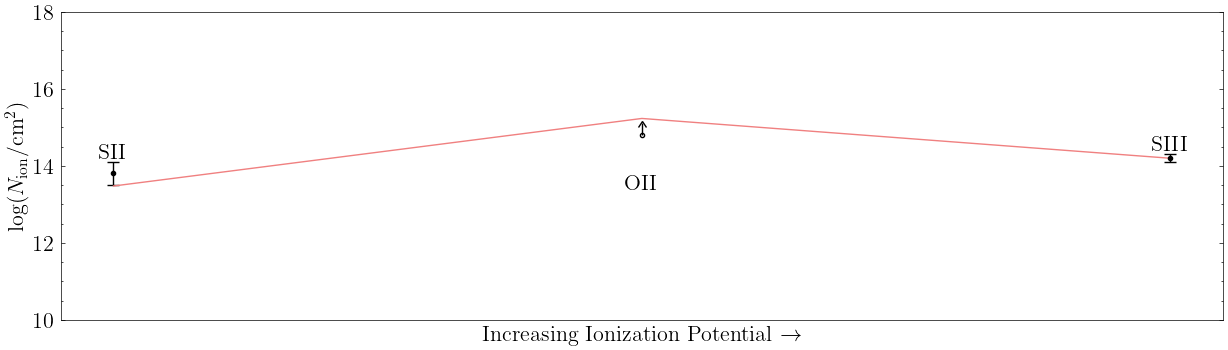

In [41]:
fig, ax = plot_column_densities_obs(logN_dict)
ax.plot(np.arange(len(logN_species_test)), logN_species_test, color='lightcoral')

In [42]:
pos = np.array([log_hdens_test, log_metals_test]) + 1e-7 * np.random.randn(200, 2)
nwalkers, ndim = pos.shape

In [43]:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability, args=(logN_dict, species_logN_interp)
)

In [44]:
sampler.run_mcmc(pos, 500, progress=True);

100%|█████████████████████████████████████████| 500/500 [00:15<00:00, 33.31it/s]


In [45]:
flat_samples = pd.DataFrame(sampler.get_chain(discard=100, flat=True), 
                                columns=['log_hdens', 'log_metals'])

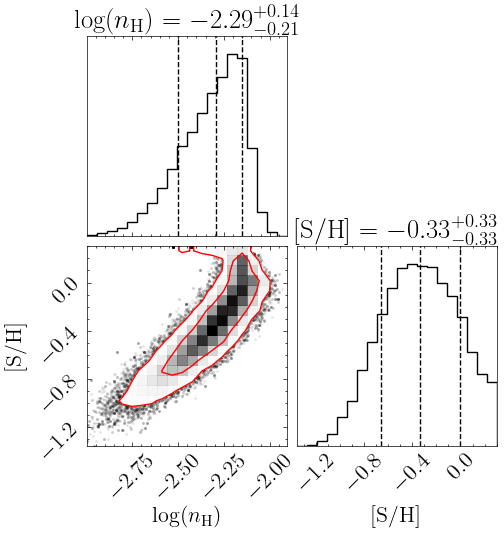

In [46]:
fig = corner.corner(
    flat_samples, quantiles = [0.16, 0.5, 0.84], show_titles=True, 
    labels=[r'$\log(n_\mathrm{H})$', r'$[\mathrm{S/H}]$'], 
    plot_density=True, levels=[0.68, 0.95], contour_kwargs={'colors':'red'}
);